# Step 5.5: Deep Learning - Autoencoder (ConvNet)

Convolutional Neural Networks (ConvNet(s)) are current state-of-the-art Deep Learning Architectures that perform well on image data and -classification problems. ConvNets "learn" e.g., image features in a spatial agnostic way: whether a line, circle or square is located at the top left, top right or center bottom of an image does not matter. ConvNets perform convolutional-like processes with miscellaneous filters to train on these features.

In our case, we train on 1-dimensional spectra. In this case, keras provides also 1D ConvNet that can be applied on our dataset: [Link](https://keras.io/api/layers/convolution_layers/convolution1d/)

In [40]:
# Import standard libraries
import os

# Import installed libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from sklearn import preprocessing

import tensorflow.keras as keras

# Matplotlib settings
# Set the dark mode and the font size and style
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

In [41]:
# Let's mount the Google Drive, where we store files and models (if applicable, otherwise work
# locally)
try:
    from google.colab import drive
    drive.mount('/gdrive')
    core_path = "/gdrive/MyDrive/Colab/asteroid_taxonomy/"
except ModuleNotFoundError:
    core_path = ""

In [42]:
# Load the level 2 asteroid data
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

In [43]:
# Allocate the spectra to one array and the classes to another one
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Main_Group"].to_list())

In [44]:
# In this example we create a single test-training split with a ratio of 0.8 / 0.2
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Create a simple, single train / test split
for train_index, test_index in sss.split(asteroids_X, asteroids_y):
    
    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_y[train_index], asteroids_y[test_index]

## Scaling the data

The data are already scaled at 550 nm. However, in our case we re-scale all spectra from 0 to 1. Due to the already present pre-processing, no exhaustive processing is needed.

Further, we also need to reshape the data for the 1D ConvNets. Normally, one would expect to use an array with m rows (number of samples), each with n dimensions (number of features, e.g., time stamps). However, for 1D ConvNets keras expectes a structure like (m, n, 1). Consequently, each individial feature needs to be stores as a single dimensional array.

In [55]:
# Scale the training and test data
X_train_scaled = np.array([(k - np.min(k)) / (np.max(k - np.min(k))) for k in X_train]).reshape(-1,49,1)
X_test_scaled = np.array([(k - np.min(k)) / (np.max(k - np.min(k)))  for k in X_test]).reshape(-1,49,1)

In [95]:
# Let's print the results
n_inputs = asteroids_X.shape[1]
print(f"Number of inputs: {n_inputs}")

# Take a look at the shape of the scaled dataset. We have 1071 spectra with 49 features, but each feature (reflectance for a particular wavelength) is stored as a 1D array (1).
print(X_train_scaled.shape)

Number of inputs: 49
(1071, 49, 1)


## Building the Autoencoder

TBW

In [104]:
# Let's create an autoencoder
n_bottleneck = 2

# Input layer
in_layer = keras.layers.Input(shape=(n_inputs,1))

# First hidden layer (encoder side)
enc_hid_lay1 = keras.layers.Conv1D(4, 3, activation="relu", padding="same")(in_layer)

# Second hidden layer (encoder side)
enc_hid_lay2 = keras.layers.Conv1D(8, 3, activation="relu", padding="same")(enc_hid_lay1)

# Encoder ("Bottleneck" of the Autoencoder)
bottleneck_lay = keras.layers.Flatten()(enc_hid_lay2)
bottleneck_lay = keras.layers.Dense(2)(bottleneck_lay)


# First hidden layer (decoder side)
reset_lay = keras.layers.Dense(49)(bottleneck_lay)

reshape_lay = keras.layers.Reshape((49,1))(reset_lay)

dec_hid_lay1 = keras.layers.Conv1DTranspose(8, 3, strides=1, activation="relu", padding="same")(reshape_lay)
dec_hid_lay2 = keras.layers.Conv1DTranspose(4, 3, strides=1, activation="relu", padding="same")(dec_hid_lay1)

# Second hidden layer (decoder side)

# Ouput layer (same size as input layer)
out_layer = keras.layers.Conv1D(1, 1, activation="sigmoid", padding="same")(dec_hid_lay2)

# Create model
model = keras.models.Model(inputs=in_layer, outputs=out_layer)

# Compile the model. Use the Mean Squred Error as the loss function. Background: An Autoencoder is a regression function
# that maps the input value directly to the output values
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        [(None, 49, 1)]           0         
_________________________________________________________________
conv1d_90 (Conv1D)           (None, 49, 4)             16        
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 49, 8)             104       
_________________________________________________________________
flatten_18 (Flatten)         (None, 392)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 786       
_________________________________________________________________
dense_24 (Dense)             (None, 49)                147       
_________________________________________________________________
reshape_16 (Reshape)         (None, 49, 1)             0  

In [105]:
# Train the model
end_epoch = 50
batch_size = 32
history = model.fit(X_train_scaled, X_train_scaled,
                    epochs=end_epoch,
                    batch_size=batch_size,
                    verbose=1, 
                    validation_data=(X_test_scaled, X_test_scaled))

Epoch 1/50
34/34 [==============================] - 1s 7ms/step - loss: 0.1036 - val_loss: 0.0922
Epoch 2/50
34/34 [==============================] - 0s 3ms/step - loss: 0.0807 - val_loss: 0.0468
Epoch 3/50
34/34 [==============================] - 0s 3ms/step - loss: 0.0424 - val_loss: 0.0331
Epoch 4/50
34/34 [==============================] - 0s 4ms/step - loss: 0.0357 - val_loss: 0.0297
Epoch 5/50
34/34 [==============================] - 0s 3ms/step - loss: 0.0289 - val_loss: 0.0268
Epoch 6/50
34/34 [==============================] - 0s 3ms/step - loss: 0.0266 - val_loss: 0.0235
Epoch 7/50
34/34 [==============================] - 0s 3ms/step - loss: 0.0239 - val_loss: 0.0200
Epoch 8/50
34/34 [==============================] - 0s 3ms/step - loss: 0.0194 - val_loss: 0.0179
Epoch 9/50
34/34 [==============================] - 0s 3ms/step - loss: 0.0185 - val_loss: 0.0167
Epoch 10/50
34/34 [==============================] - 0s 3ms/step - loss: 0.0171 - val_loss: 0.0156
Epoch 11/50
34/34 [

## The loss function

Let's show the loss of the training and test data. As you can see, the minimum-plateau is reached quite fast. The test data performs slightly better than the training data, since the loss results for the training data are based on an average of the batch size. The test results are based on all data.

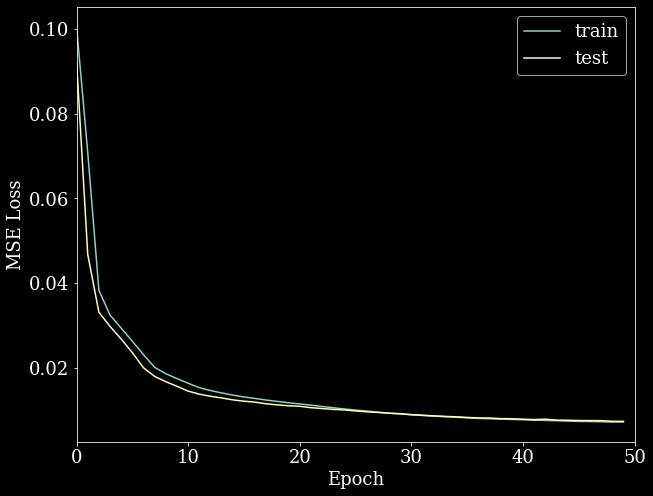

In [106]:
# plot the training and validation loss
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

# Add legend and labels
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")

# Limit the x axis
plt.xlim(0, end_epoch)

# ... aaaaand plot!
plt.show()

## Signal Reconstruction

... can be done by using the entire model to predict the output spectra. The following code snippet takes a signal (change the index value in the first line to use any other signal) and predicts the Autoencoder based spectrum.

As one can see, the results are "quite ok" but far from perfect. The shape of the spectra can be reproduced. However, the signals are quite noisy. The question is now: Do we have a low-dimensional clustering?

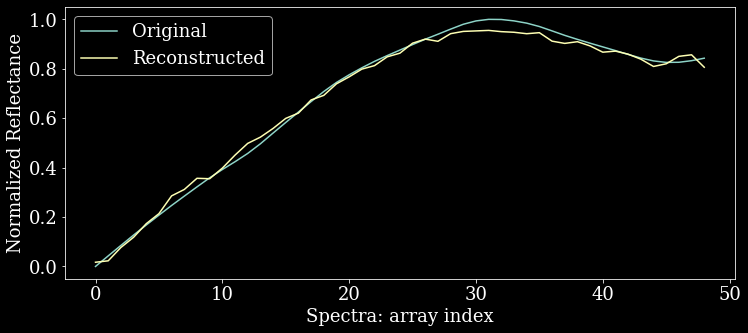

In [107]:
# Which index shall be displayed?
index_val = 10

# plot the training and reconstructed data
plt.figure(figsize=(12,5))
plt.plot(X_train_scaled[index_val], label='Original')
plt.plot(model.predict(X_train_scaled)[index_val], label='Reconstructed')

# Add legend and labels
plt.legend()
plt.xlabel("Spectra: array index")
plt.ylabel("Normalized Reflectance")

# ... aaaaand plot!
plt.show()

In [108]:
# Create dataframe that contains the encoder values (2 values at bottleneck) and the corresponding
# class to see whether the autoencoder values cluster in a way

# Build the encoder
encoder = keras.models.Model(inputs=in_layer, outputs=bottleneck_lay)

# Encode the trained spectra
X_train_encoded = encoder.predict(X_train_scaled)

# Create the dataframe
encoded_train_df = pd.DataFrame(np.hstack((X_train_encoded, y_train[np.newaxis].transpose())),
                                columns=["enc1", "enc2", "class"])

# Change the dtype to float
encoded_train_df.loc[:, "enc1"] = encoded_train_df["enc1"].astype(float)
encoded_train_df.loc[:, "enc2"] = encoded_train_df["enc2"].astype(float)

## Low Dimensional Space

Now let's take a look at the 2D Autoencoder space. The main group classes are colored and afterwards plotted. One can see that the C and S class can be distinguished well. The C Class shows also local clusters that would be investigated further. The group "other" (outlier) are separated from the rest in two "regions" and the X class overlaps with the S and C class.

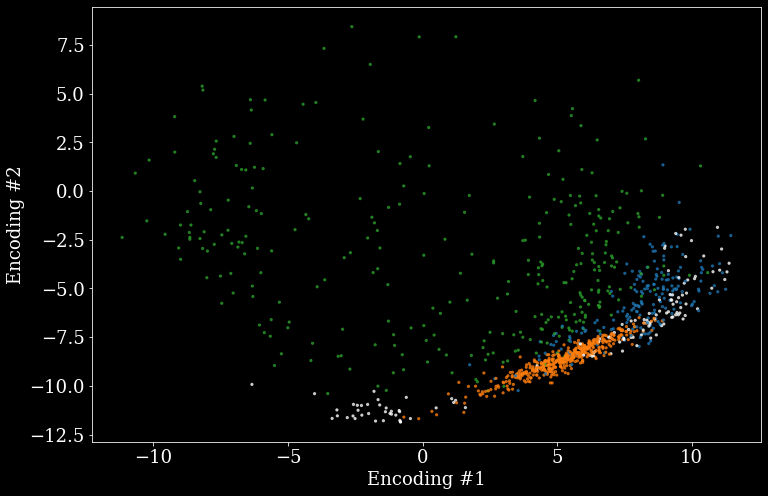

In [109]:
# Plot now the autoencoder values

# Create a dictionary to color the classes
color_dict = {'Other': 'w',
              'S': 'tab:orange',
              'C': 'tab:green',
              'X': 'tab:blue'}

# Set a plot
plt.figure(figsize=(12,8))

# Create a scatter plot with the encoder values and assign the colors to the corresponding classes
plt.scatter(encoded_train_df["enc1"],
            encoded_train_df["enc2"],
            marker='o',
            s=5,
            alpha=0.7,
            color=encoded_train_df.apply(lambda x: color_dict.get(x["class"]), axis=1).values)

# Set xlabels
plt.xlabel("Encoding #1")
plt.ylabel("Encoding #2")

# Save the image and show it, too
plt.savefig("asteroid_spectra_AE_FF_2dim.png")
plt.show()

## Summary & Outlook